Algoritmos

In [1]:
#The first byte of the record stores the size.
#The string values are encoded using utf-8,
#which can use more bytes than the number of
#characters of the string.
class Record:
  def __init__(self, record_size, value=""):
    self.byte_array = bytearray([0] * record_size)
    self.write(value)

  # creates a record from a bytearray
  def create(record_size, byte_array):
    string_bytes = byte_array[1:1+byte_array[0]]
    return Record(record_size, string_bytes.decode('utf-8'))

  def write(self, value):
    if(not isinstance(value, str)):
       raise TypeError(f"The value must be str!")

    string_bytes = value.encode('utf-8')

    if (1+len(string_bytes))> len(self.byte_array):
      raise ValueError(f"Record overflow!")

    self.byte_array[0] = len(string_bytes)
    self.byte_array[1:1+len(string_bytes)] = string_bytes

  def read(self):
    string_bytes = self.byte_array[1:1+self.byte_array[0]]
    return string_bytes.decode('utf-8')

  def size(self):
    return len(self.byte_array)

  def bytes(self):
    return self.byte_array.copy()

  def __str__(self):
    return f"value:{self.read()}, bytes occupied:{1+self.byte_array[0]} , capacity:{self.size()}"

In [2]:
rec = Record(6,"joão")
print(rec.bytes())
print(rec)

bytearray(b'\x05jo\xc3\xa3o')
value:joão, bytes occupied:6 , capacity:6


In [3]:
# Block and Page are synomyms
class Block:
  def __init__(self, block_size, record_size):
    self.records = []
    self.block_size = block_size
    self.record_size = record_size
    self.capacity = (block_size-1) // record_size

  # creates a block from a bytearray
  def create(block_size, record_size, byte_array):
    block = Block(block_size, record_size)

    pos = 1
    for _ in range(byte_array[0]):
      rec = Record.create(record_size, byte_array[pos:pos+record_size] )
      block.add(rec.read())
      pos += record_size

    return block

  def add(self, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    if(self.size() < self.capacity):
      self.records.append(Record(self.record_size, key))
    else:
      raise ValueError("The block is full!")

  def addIndex(self, index, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    if(self.size() < self.capacity):
      self.records.insert(index, Record(self.record_size, key))
    else:
      raise ValueError("The block is full!")

  def remove(self, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    rec = self.search(key)
    if(rec):
      return self.records.remove(rec)
    return None

  def removeIndex(self, index):
    if(not isinstance(index, int)):
       raise TypeError(f"The index must be int!")
    return self.records.pop(index)

  def removeLast(self):
    if len(self.records)>0:
      return self.records.pop()
    return None

  def read(self):
    str=""
    for rec in self.records:
      str += rec.read() + "\n"
    return str;

  def search(self, key):
    if(not isinstance(key, str)):
       raise TypeError(f"The key must be str!")

    for i in range(len(self.records)):
      if(self.getRecord(i).read()==key):
        return i
    return -1

  # returns a list of records, within the range keyA (inclusive) and KeyB (exclusive)
  def rangeSearch(self, keyA, keyB):
    if((not isinstance(keyA, str)) or (not isinstance(keyB, str))):
       raise TypeError(f"The key must be str!")

    ret = []
    for rec in self.records:
      recValue = rec.read()
      if(recValue>=keyA and recValue<keyB):
        ret.append(recValue)
    return ret

  def getRecord(self, index):
    return self.records[index]

  def size(self):
    return len(self.records)

  def isFull(self):
    return self.size()==self.capacity

  def bytes(self):
    byte_array = bytearray([0] * self.block_size)
    byte_array[0] = self.size()
    pos = 1
    for rec in self.records:
      byte_array[pos:pos+rec.size()] = rec.bytes()
      pos += rec.size()

    return byte_array

In [4]:
block = Block(64, 4)
print(f"block capacity: {block.capacity}")
print(f"block size: {block.size()}")

block.add("V1")
block.add("V2")
block.add("V3")
block.add("V5")
block.add("V6")
block.add("V7")

block.addIndex(2, "V22")
block.removeLast()

print(block.read())

print(f"getRecord(0): {block.getRecord(0)}")
print(f"search: {block.search('V5')}")
print(f"range search: {block.rangeSearch('V3','V7')}")
print(f"block bytes: {block.bytes()}")


block capacity: 15
block size: 0
V1
V2
V22
V3
V5
V6

getRecord(0): value:V1, bytes occupied:3 , capacity:4
search: 4
range search: ['V3', 'V5', 'V6']
block bytes: bytearray(b'\x06\x02V1\x00\x02V2\x00\x03V22\x02V3\x00\x02V5\x00\x02V6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')


In [5]:
import os
class HeapFile:

  def __init__(self, filename, block_size, record_size):
    self.filename = filename
    self.block_size = block_size
    self.record_size = record_size

    #print(f"os.path.abspath(filename): {os.path.abspath(filename)}")

    if(os.path.exists(filename)):
      self.blocks = os.path.getsize(filename)//block_size
    else:
      self.blocks = 1
      with open(self.filename, "wb") as file:
        file.write(Block(block_size, record_size).bytes())

  def add(self, key):
    block = self.read(self.blocks-1)

    if(block.isFull()):
      self.blocks+=1
      block = Block(self.block_size, self.record_size)

    block.add(key)
    self.write(self.blocks-1, block)

  def remove(self, key):
    (block_id, rec_id) = self.search(key)
    if block_id>=0:
      block = self.read(block_id)
      block.removeIndex(rec_id)
      self.write(block_id, block)

  def scan(self, output=True):
    for i in range(self.blocks):
      if output:
        print(self.read(i).read())
      else:
        self.read(i).read()

  # returns the record, containing the key
  def search(self, key):
    for i in range(self.blocks):
      block = self.read(i)
      rec_id = block.search(key)

      if(rec_id>=0):
        return (i, rec_id)
    return (-1, -1)

  # returns a list of records, within the range keyA (inclusive) and KeyB (exclusive)
  def rangeSearch(self, keyA, keyB):
    result = []
    for i in range(self.blocks):
      result += self.read(i).rangeSearch(keyA, keyB)
    return result

  def write(self, block_id, block):
    if(not isinstance(block, Block)):
       raise TypeError(f"The block must by of Block type!")

    with open(self.filename, "r+b") as file:
      file.seek(self.block_size * (block_id))
      file.write(block.bytes())

  def read(self, block_id):
    with open(self.filename, "r+b") as file:
      file.seek(self.block_size *(block_id))
      byte_array = file.read(self.block_size)
      return Block.create(self.block_size, self.record_size, byte_array)



In [6]:
filename  = "heapfile.bin"
fileType = HeapFile(filename, 16, 4)

fileType.add("V1")
fileType.add("V2")
fileType.add("V3")

fileType.add("V4")
fileType.add("V5")
fileType.add("V6")

fileType.add("V7")
fileType.add("V8")

fileType.scan()

print(f"blocks:{fileType.blocks}")

block1 = fileType.read(0)
print(f"block1.getRecord(0)={block1.getRecord(0)}")

block2 = fileType.read(1)
print(f"block2.getRecord(2)={block2.getRecord(2)}")

block3 = fileType.read(2)
print(f"block3.getRecord(1)={block3.getRecord(1)}")

os.remove(filename)

V1
V2
V3

V4
V5
V6

V7
V8

blocks:3
block1.getRecord(0)=value:V1, bytes occupied:3 , capacity:4
block2.getRecord(2)=value:V6, bytes occupied:3 , capacity:4
block3.getRecord(1)=value:V8, bytes occupied:3 , capacity:4


In [14]:
import os
#import math
class SortedFile(HeapFile):

  def add(self, key):
    start = 0
    end = self.blocks - 1
    block_id = 0
    rec_id = 0

    while start <= end:
        #print(f"Start: {start}, End: {end}")

        middle_block_id = self.__filePartition(start, end)

        middle_block = self.read(middle_block_id)

        if middle_block.size() == 0:
            block_id = middle_block_id
            rec_id = 0
            break
        else:
            position = self.__findPosition(middle_block,key)

        if position == middle_block.capacity:
            #print(f"Block overflow. Block ID: {middle_block_id}, Position: {position}, Start: {start}, End: {end}")
            if start < end:
                if middle_block.isFull():
                    start = middle_block_id + 1
                    end = self.blocks - 1
                    continue
                else:
                    block_id = middle_block_id
                    rec_id = position
                    break
            else:                
                block_id = middle_block_id + 1
                rec_id = 0
                break

        elif position == 0:
            if start != end: 
                if middle_block.isFull():
                    start = 0
                    end = middle_block_id - 1
                    continue
                else:
                    block_id = middle_block_id
                    rec_id = position
                    break
            else:
                block_id = middle_block_id
                rec_id = position
                break
        else:
            rec_id = position
            block_id = middle_block_id
            break

    #print(f"Key: {key}, Block ID: {block_id}, Record ID: {rec_id}")

    if block_id == self.blocks:
        self.blocks+=1
        block = Block(self.block_size, self.record_size)
        block.add(key)
        self.write(self.blocks-1, block)
    else:
        block = self.read(block_id)

        if block.isFull():
            self.__addAndShift(key, rec_id, block_id)
        else:
            block.addIndex(rec_id, key)
            self.write(block_id, block)   

  def remove(self, key):
    keySearchResult = self.search(key)

    if keySearchResult:
        blockId = keySearchResult[0]
        recIndex = keySearchResult[1]
        
        blockToRemoveFrom = blockId
        indexToBeRemoved = recIndex

        removedElement = (blockId, recIndex)        

        #block = self.read(blockId)
        #block.removeIndex(recIndex)
        #self.write(blockId, block)

        # print(f"Current Block ID: {blockId}, Total Blocks: {self.blocks}")
        if blockId < self.blocks:
            # print(f"Current Block ID: {blockId}, Total Blocks: {self.blocks}")
            # nextBlockId = blockId + 1

            #if nextBlockId < self.blocks:
            #    nextBlock  = self.read(nextBlockId)
                # print(f"Next Block ID: {nextBlockId}")
            blockIndex = 0
            for blockIndex in range(blockId, self.blocks):
                block = self.read(blockIndex)
                hasNextBlock = False
                
                if blockIndex < self.blocks - 1:
                    hasNextBlock = True
                    nextBlockId = blockIndex + 1
                    nextBlock = self.read(nextBlockId)
                
                                   
                if  blockIndex == blockToRemoveFrom:                        
                    block.removeIndex(indexToBeRemoved)
                    self.write(blockIndex, block)                      
                        
                if hasNextBlock:
                    nextBlockFirstRecord = nextBlock.removeIndex(0)
                    self.write(nextBlockId, nextBlock)
                    
                    block.add(nextBlockFirstRecord.read())
                    self.write(blockIndex, block)
                #else:
                 #   nextRecordInBlock = block.removeIndex(index + 1)
                 #   block.addIndex(index, nextRecordInBlock.read())
                 #   self.write(blockIndex, block)
                #recIndex = 0
                #nextBlockId += 1

                #if nextBlockId < self.blocks:
                #    nextBlock = self.read(nextBlockId)
           # blockIndex -= 1
            
            if blockIndex != self.blocks:
                lastBlock = self.read(blockIndex)
                if lastBlock.size() == 0:
                    self.blocks -= 1
                


        return removedElement
    else:
        raise ValueError(f"Key not found")


  def search(self, key):
    start = 0
    end = self.blocks - 1
    block_id = 0
    rec_id = None

    while start <= end:
        #print(f"Start: {start}, End: {end}")
        block_id = self.__filePartition(start, end)

        middle_block = self.read(block_id)

        #print(f"Block ID: {block_id}")
        if middle_block.size() == 0:
            return False
        else:
            rec_id = self.__searchInBlock(middle_block, key)
            if rec_id != -1:
                return block_id, rec_id
            elif key > middle_block.getRecord(middle_block.size() - 1).read():
                start = block_id + 1
                end = self.blocks - 1
                #print(f"Start BIGGER: {start}, End: {end}")
            elif key < middle_block.getRecord(0).read():
                start = 0
                end = block_id - 1
                #print(f"Start SMALLER: {start}, End: {end}")  
            else:
                break
        #print(f"Start: {start}, End: {end}") 

    if rec_id != -1:
        return block_id, rec_id
    else:
        return False

  def __searchInBlock(self,block, key):
    #print(f"Block Size: {block.size()}")
    start = 0
    end = block.size() - 1
    block_id = 0
    rec_id = 0

    while start <= end:
        middle_id = (start + end) // 2
        middleRecord = block.getRecord(middle_id)

        middleKey = middleRecord.read()

        #print(f"Middle Key: {middleKey}, Key: {key}")
        if middleKey == key:
            #print("middleKey == key")
            return middle_id
        elif key < middleKey:
            end = middle_id - 1
        else:
            start = middle_id + 1

    return -1


  def rangeSearch(self, keyA, keyB):
    print('Sorted Range Search ')
    keyASearchResult = self.search(keyA)
    keyBSearchResult = self.search(keyB)

    result = []
    if keyASearchResult == False or keyBSearchResult == False:
        return []
    else:
        for i in range(keyASearchResult[0], keyBSearchResult[0] + 1 ):
            result += self.read(i).rangeSearch(keyA, keyB)
        return result

  def __filePartition(self, start, end):
    return (start + end) // 2   

  def __findPosition(self, block, key):
    # print(f"Block Capacity:{block.capacity}")
    position = 0
    for index in range(block.size()):
        if key >= block.getRecord(index).read():
            position = index + 1
            # print(f"Key: {key}, Position: {position}")

    #if position == block.capacity:
    #    position -= 1
    return position


  def __addAndShift(self, key, position, block_id):    
    block = self.read(block_id)
    #print(f"__addAndShift, Key: {key}, Position: {position}, Block ID: {block_id}, Block Capacity: {block.capacity}")

    lastRecord = block.getRecord(block.capacity - 1)
    firstRecord = block.getRecord(0)

    #print(f"__addAndShift, Key: {key}, Last Key: {lastRecord.read()}, Position: {position}")
    lastKey = lastRecord.read()
    firstKey = firstRecord.read()

    if key >= lastKey:                
        self.__shift(key, block_id + 1)
    else:
        lastRecord = block.removeLast()
        block.addIndex(position, key)
        self.write(block_id, block)
        self.__shift(lastKey, block_id + 1) 


  def __shift(self, key,block_id):
    #print(f"__shift, Key: {key}, Block ID: {block_id}, Blocks: {self.blocks}")
    block = None

    if block_id == self.blocks:
        self.blocks += 1
        block = Block(self.block_size, self.record_size)
    else:
        #print(f"Reading Block: {block_id}")
        block = self.read(block_id)

    currentBlockId = block_id
    lastRecord = None
    currentKey = key

    if not block.isFull():
        block.addIndex(0, currentKey)
        self.write(block_id, block)
    else:    
        while block.isFull():
            #print('Block is Full')
            lastRecord = block.removeLast()


            block.addIndex(0,currentKey)
            self.write(currentBlockId, block)
            currentKey = lastRecord.read()        


            currentBlockId += 1

            if currentBlockId == self.blocks:
                self.blocks += 1
                block = Block(self.block_size, self.record_size)

                block.addIndex(0, currentKey)
                self.write(currentBlockId, block)
            else:
                block = self.read(currentBlockId)

                if not block.isFull():
                    block.addIndex(0,currentKey)
                    self.write(currentBlockId, block)
                    break

  def __unshift(self, block, rec_id):
    pass
        
        
            
            

In [15]:
filename  = "sortedfile.bin"
fileType = SortedFile(filename, 16, 4)

dir(fileType)
fileType.add("V05")
fileType.add("V06")
fileType.add("V21")

fileType.add("V10")
fileType.add("V12")
fileType.add("V11")

fileType.add("V07")
fileType.add("V01")
fileType.add("V02")

fileType.add("V08")
fileType.add("V03")
fileType.add("V09")

fileType.add("V00")
fileType.add("V10")
fileType.add("V12")

fileType.add("V11")
fileType.add("V13")

fileType.scan()


print(f"Searcing V13: {fileType.search('V13')}")

print(f"Searcing V03: {fileType.search('V03')}")

#print(f"Searcing V05: {fileType.search('V05')}")

print(f"Searcing V90: {fileType.search('V90')}")

print(f"Searcing A90: {fileType.search('A90')}")

print(f"Range Search: {fileType.rangeSearch('V02','V09')}")
dir(fileType)
print(f"Removing V06: {fileType.remove('V06')}")
print(f"Removing V13: {fileType.remove('V13')}")

fileType.scan()
print(f"Total Blocks: {fileType.blocks}")
os.remove(filename)

V00
V01
V02

V03
V05
V06

V07
V08
V09

V10
V10
V11

V11
V12
V12

V13
V21

Searcing V13: (5, 0)
Searcing V03: (1, 0)
Searcing V90: False
Searcing A90: False
Sorted Range Search 
Range Search: ['V02', 'V03', 'V05', 'V06', 'V07', 'V08']
Removing V06: (1, 2)
Removing V13: (4, 2)
V00
V01
V02

V03
V05
V07

V08
V09
V10

V10
V11
V11

V12
V12
V21

Total Blocks: 5


In [78]:
#Create files
import time
import string
import random
import math

PAGE_SIZE   = 4096
RECORD_SIZE = 128

def creationTime(FileType, size):
  random.seed(size)

  filename = f"{FileType.__name__}_{PAGE_SIZE}P_{RECORD_SIZE}R_{size}L.bin"
  if(os.path.exists(filename)):
    os.remove(filename)

  start = time.time()
  S = FileType(filename, PAGE_SIZE, RECORD_SIZE)
  for i in range(size):
    T  = "".join( [random.choice(string.ascii_lowercase) for i in range(random.randint(1, RECORD_SIZE-10))])
    S.add(T)

  end = time.time()
  return end - start


#defines the file organization types
fileStructures = [HeapFile]

records = [100,200,300,400,500]

mapSizeToTime = dict()
for i in range(len(records)):
  #map list size to algorithm average time
  for fileType in fileStructures:
    print(f"Creating {fileType.__name__} {i+1} with {records[i]} records...")
    mapSizeToTime[f"{fileType.__name__ }##{records[i]}"] = creationTime(fileType, records[i])
  print("")

print(f"Finish.")

Creating HeapFile 1 with 100 records...

Creating HeapFile 2 with 200 records...

Creating HeapFile 3 with 300 records...

Creating HeapFile 4 with 400 records...

Creating HeapFile 5 with 500 records...

Finish.


In [ ]:
#collect data about the functions
import time
import string
import random
import math

#defines the number of times each algorithm will be processed to obtain the average time
num_rounds = 100
PAGE_SIZE   = 4096
RECORD_SIZE = 128

#calculates the executions average time
def avgTime(FileType, func, size):
  t = 0

  filename = f"{FileType.__name__}_{PAGE_SIZE}P_{RECORD_SIZE}R_{size}L.bin"
  S = FileType(filename, PAGE_SIZE, RECORD_SIZE)

  for i in range(num_rounds):
    random.seed(size+i)

    start = time.time()

    if "add"==FileType.__name__:
      T  = "".join( [random.choice(string.ascii_lowercase) for i in range(random.randint(1, RECORD_SIZE-10))])
      FileType.add(T)
      assert FileType.search(T)
    elif "scan"==FileType.__name__:
      FileType.scan(False)
    elif "search"==FileType.__name__:
      randomBlockId= random.randint(1, FileType.blocks)
      block = FileType.read(randomBlockId)
      key = block.getRecord(random.randint(block.size())).read()
      (block_id, rec_id) = FileType.search(key)
      assert randomBlockId== block_id
    elif "rangeSearch"==FileType.__name__:
      blockA = FileType.read(random.randint(1, FileType.blocks))
      keyA = block.getRecord(random.randint(block.size())).read()
      blockB = FileType.read(random.randint(1, FileType.blocks))
      keyB = block.getRecord(random.randint(block.size())).read()

      ret = FileType.rangeSearch(min(keyA,keyB), max(keyA,keyB))
      assert ret
    elif "remove"==FileType.__name__:
      block_id = random.randint(1, FileType.blocks)
      block = FileType.read(block_id)
      blockSize = block.size()
      FileType.remove(block.getRecord(random.randint(block.size())).read())
      block = FileType.read(block_id)
      assert blockSize-1 == block.size()
    end = time.time()
    t += end - start

  return t/num_rounds


#defines the file organization types
fileStructures = [HeapFile]

#defines the algorithms to be processed
algorithms = ["add","scan","search","rangeSearch","remove"]

sizes = [100,200,300,400,500]

mapSizeToTime = dict()
for i in range(len(sizes)):
  print(f"Starting collect {i+1}")

  #map list size to algorithm average time
  for fileType in fileStructures:
    for algorithm in algorithms:
      print(f"  > {fileType.__name__}.{algorithm}")
      mapSizeToTime[f"{fileType.__name__}.{algorithm}##{sizes[i]}"] = avgTime(fileType, algorithm, sizes[i])

print(f"Finish data collection")

Starting collect 1
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
Starting collect 2
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
Starting collect 3
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
Starting collect 4
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
Starting collect 5
  > HeapFile.add
  > HeapFile.scan
  > HeapFile.search
  > HeapFile.rangeSearch
  > HeapFile.remove
Finish data collection


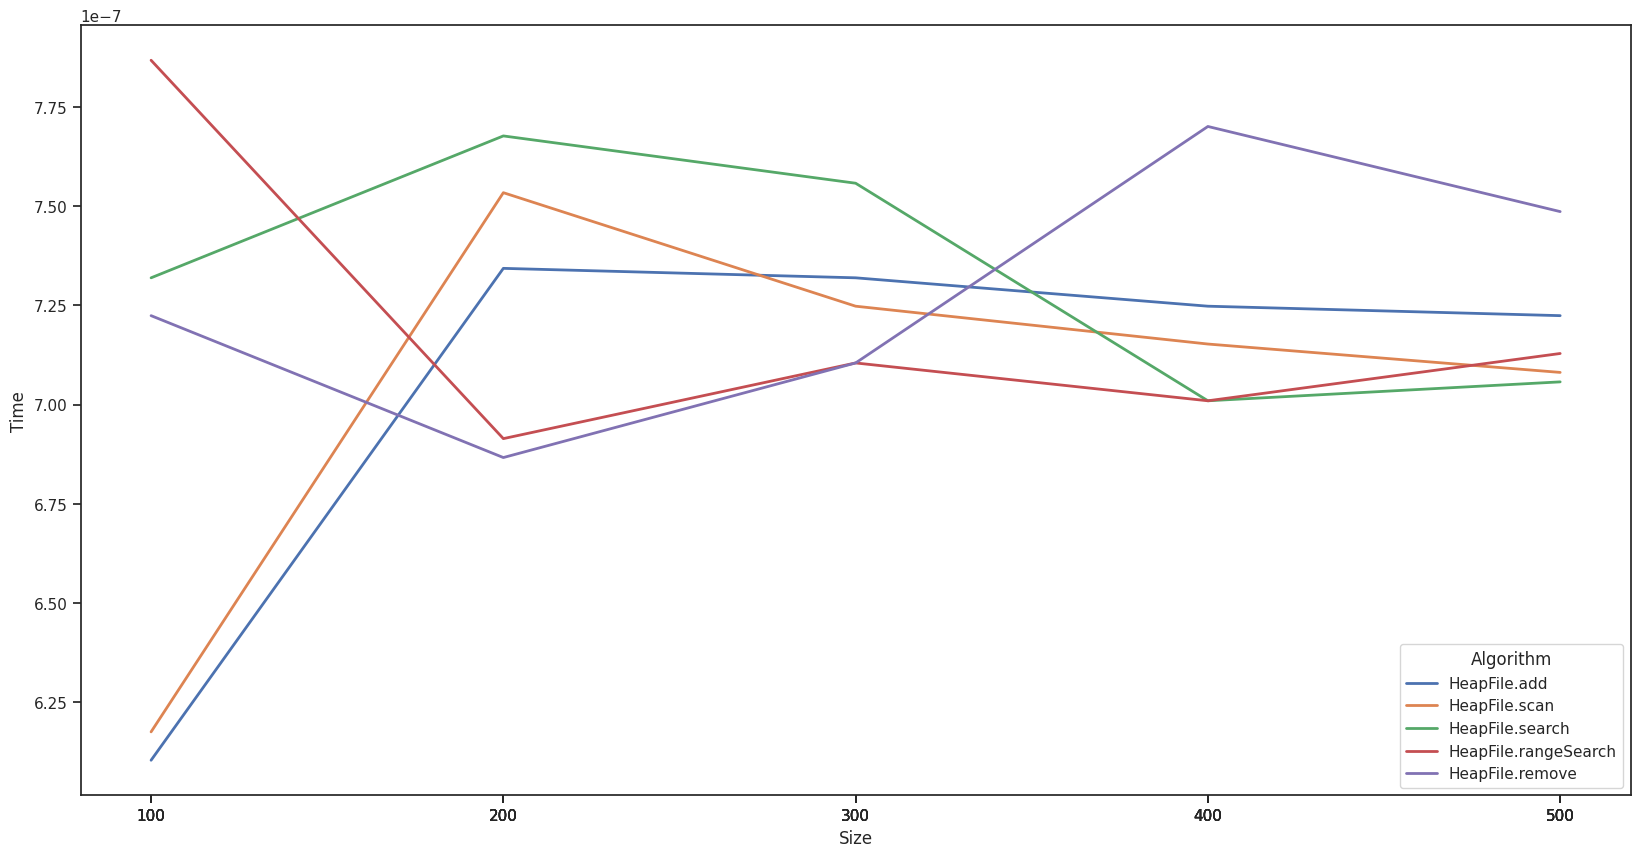

<Figure size 2000x1000 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame.from_dict(mapSizeToTime, orient='index', columns=['Time'])
df['Algorithm'] = [i.split("##")[0] for i in df.index]
df['Size'] = [int(i.split("##")[1]) for i in df.index]
df

#Defines font size and line width
sns.set(font_scale=1, style="ticks", rc={"lines.linewidth": 2})

#Defines plot size
plt.rcParams['figure.figsize'] = [20, 10]

chart = sns.lineplot(x='Size', y='Time', hue='Algorithm', data=df)

#plt.yscale('log')
fig = plt.figure()
chart.set(xticks=[i for i in df.Size])
plt.show()

In [ ]:
df

,Time,Algorithm,Size
HeapFile.add##100,6.103516e-07,HeapFile.add,100
HeapFile.scan##100,6.175041e-07,HeapFile.scan,100
HeapFile.search##100,7.319450e-07,HeapFile.search,100
HeapFile.rangeSearch##100,7.867813e-07,HeapFile.rangeSearch,100
HeapFile.remove##100,7.224083e-07,HeapFile.remove,100
HeapFile.add##200,7.343292e-07,HeapFile.add,200
HeapFile.scan##200,7.534027e-07,HeapFile.scan,200
HeapFile.search##200,7.677078e-07,HeapFile.search,200
HeapFile.rangeSearch##200,6.914139e-07,HeapFile.rangeSearch,200
HeapFile.remove##200,6.866455e-07,HeapFile.remove,200
